#Classifying Countries based on Policy Stringency
With VIF Filerting and using ML Models


Dataset Columns: Index(['country', 'geoid', 'iso', 'd', 'cases', 'deaths', 'school',
       'school_local', 'domestic', 'domestic_local', 'travel',
       'travel_partial', 'travel_dom', 'travel_dom_partial', 'curf',
       'curf_partial', 'mass', 'mass_partial', 'sport', 'sport_partial',
       'rest', 'rest_local', 'testing', 'testing_narrow', 'masks',
       'masks_partial', 'surveillance', 'surveillance_partial', 'state',
       'state_partial', 'cash', 'wage', 'credit', 'taxc', 'taxd', 'export',
       'rate', 'Rigidity_Public_Health', 'Economic_Measures',
       'population_2019', 'continent'],
      dtype='object')
Column 'Policy_Stringency' not found. Creating based on thresholds.
Policy Stringency Distribution:
 Policy_Stringency
Medium    21009
Low       20912
High      20779
Name: count, dtype: int64


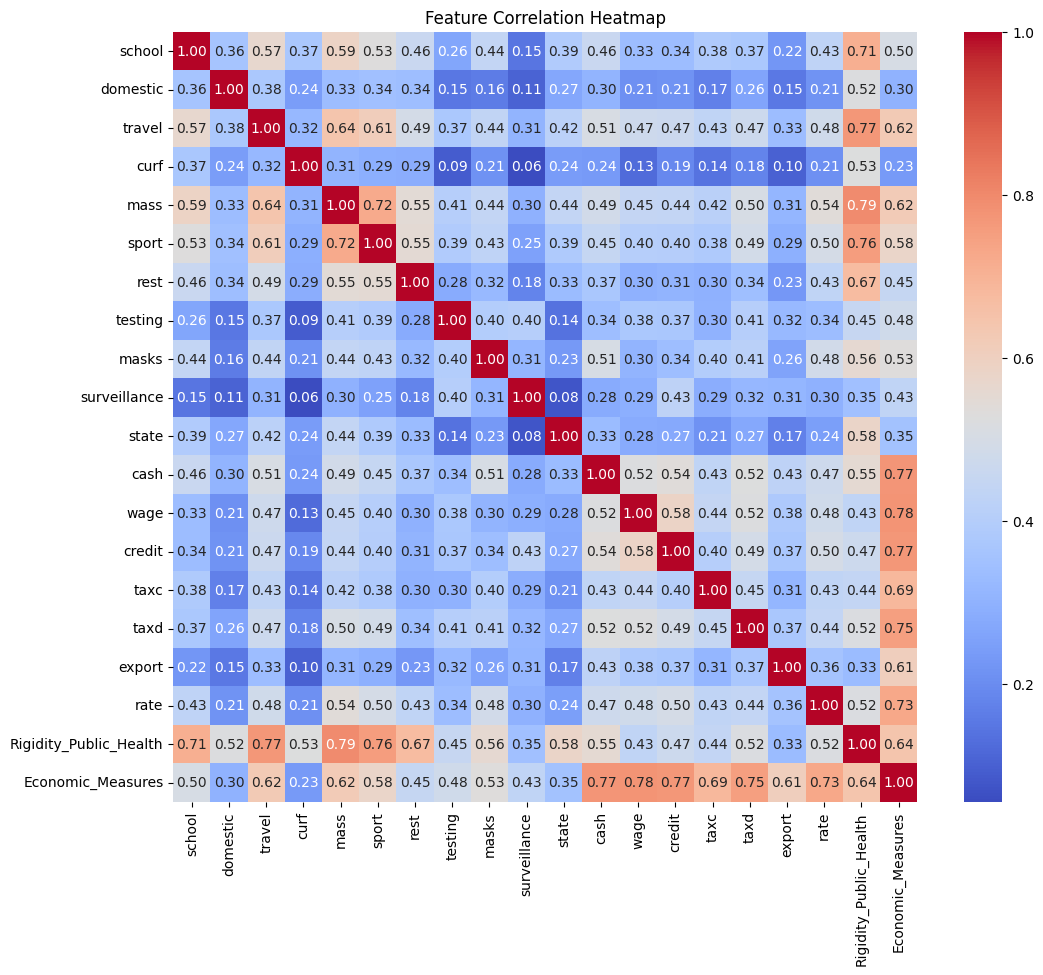

Selected Features after VIF filtering: ['school', 'domestic', 'travel', 'curf', 'mass', 'sport', 'rest', 'testing', 'masks', 'surveillance', 'state']

Logistic Regression Results:
              precision    recall  f1-score   support

        High       0.77      0.82      0.80      4156
         Low       0.93      0.93      0.93      4182
      Medium       0.74      0.69      0.72      4202

    accuracy                           0.81     12540
   macro avg       0.81      0.82      0.81     12540
weighted avg       0.81      0.81      0.81     12540

Confusion Matrix:
 [[3414    0  742]
 [   0 3889  293]
 [1008  278 2916]]

Gradient Boosting Results:
              precision    recall  f1-score   support

        High       0.78      0.87      0.82      4156
         Low       0.93      0.93      0.93      4182
      Medium       0.78      0.69      0.73      4202

    accuracy                           0.83     12540
   macro avg       0.83      0.83      0.83     12540
weighted av

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load dataset
df = pd.read_csv("/content/preprocessed_dataset.csv")

# Checking column names
print("Dataset Columns:", df.columns)

# Creating Policy_Stringency if not found
if 'Policy_Stringency' not in df.columns:
    print("Column 'Policy_Stringency' not found. Creating based on thresholds.")
    if 'Rigidity_Public_Health' in df.columns and 'Economic_Measures' in df.columns:
        df['Policy_Stringency'] = pd.qcut(df['Rigidity_Public_Health'] + df['Economic_Measures'],
                                          q=3, labels=['Low', 'Medium', 'High'])
    else:
        raise ValueError("Required columns for classification are missing.")

# Checking class distribution
print("Policy Stringency Distribution:\n", df['Policy_Stringency'].value_counts())

# Selecting relevant features
features = ['school', 'domestic', 'travel', 'curf', 'mass', 'sport', 'rest', 'testing',
            'masks', 'surveillance', 'state', 'cash', 'wage', 'credit', 'taxc', 'taxd',
            'export', 'rate', 'Rigidity_Public_Health', 'Economic_Measures']
target = 'Policy_Stringency'

# Compute correlation matrix
correlation_matrix = df[features].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

# Remove highly correlated features (threshold > 0.85)
high_corr_features = set()
correlation_threshold = 0.85
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            high_corr_features.add(colname)

filtered_features = [f for f in features if f not in high_corr_features]

# Check VIF to remove highly multicollinear features
def calculate_vif(df, features):
    X = df[features]
    X = X.fillna(0)  # Handling missing values
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calculate VIF and remove features with VIF > 10
vif_df = calculate_vif(df, filtered_features)
filtered_features = vif_df[vif_df["VIF"] < 10]["Feature"].tolist()
print("Selected Features after VIF filtering:", filtered_features)

# Splitting data into train and test
X = df[filtered_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalizing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Function to train and evaluate a model
def train_and_evaluate(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{model_name} Results:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return accuracy_score(y_test, y_pred)

# Model 1: Logistic Regression
logreg = LogisticRegression()
acc_logreg = train_and_evaluate(logreg, "Logistic Regression")

# Model 2: Gradient Boosting Classifier
gb = GradientBoostingClassifier()
acc_gb = train_and_evaluate(gb, "Gradient Boosting")

# Model 3: Decision Tree Classifier
dt = DecisionTreeClassifier()
acc_dt = train_and_evaluate(dt, "Decision Tree")

# Model 4: Naive Bayes Classifier
nb = GaussianNB()
acc_nb = train_and_evaluate(nb, "Naive Bayes")

# Compare Model Accuracies
model_accuracies = {
    "Logistic Regression": acc_logreg,
    "Gradient Boosting": acc_gb,
    "Decision Tree": acc_dt,
    "Naive Bayes": acc_nb
}

# Print model performance summary
print("\nModel Performance Summary:")
for model, acc in model_accuracies.items():
    print(f"{model}: {acc:.4f}")


#ML Models without VIF Filtering

Dataset Columns: Index(['country', 'geoid', 'iso', 'd', 'cases', 'deaths', 'school',
       'school_local', 'domestic', 'domestic_local', 'travel',
       'travel_partial', 'travel_dom', 'travel_dom_partial', 'curf',
       'curf_partial', 'mass', 'mass_partial', 'sport', 'sport_partial',
       'rest', 'rest_local', 'testing', 'testing_narrow', 'masks',
       'masks_partial', 'surveillance', 'surveillance_partial', 'state',
       'state_partial', 'cash', 'wage', 'credit', 'taxc', 'taxd', 'export',
       'rate', 'Rigidity_Public_Health', 'Economic_Measures',
       'population_2019', 'continent'],
      dtype='object')
Column 'Policy_Stringency' not found. Creating based on thresholds.
Policy Stringency Distribution:
 Policy_Stringency
Medium    21009
Low       20912
High      20779
Name: count, dtype: int64


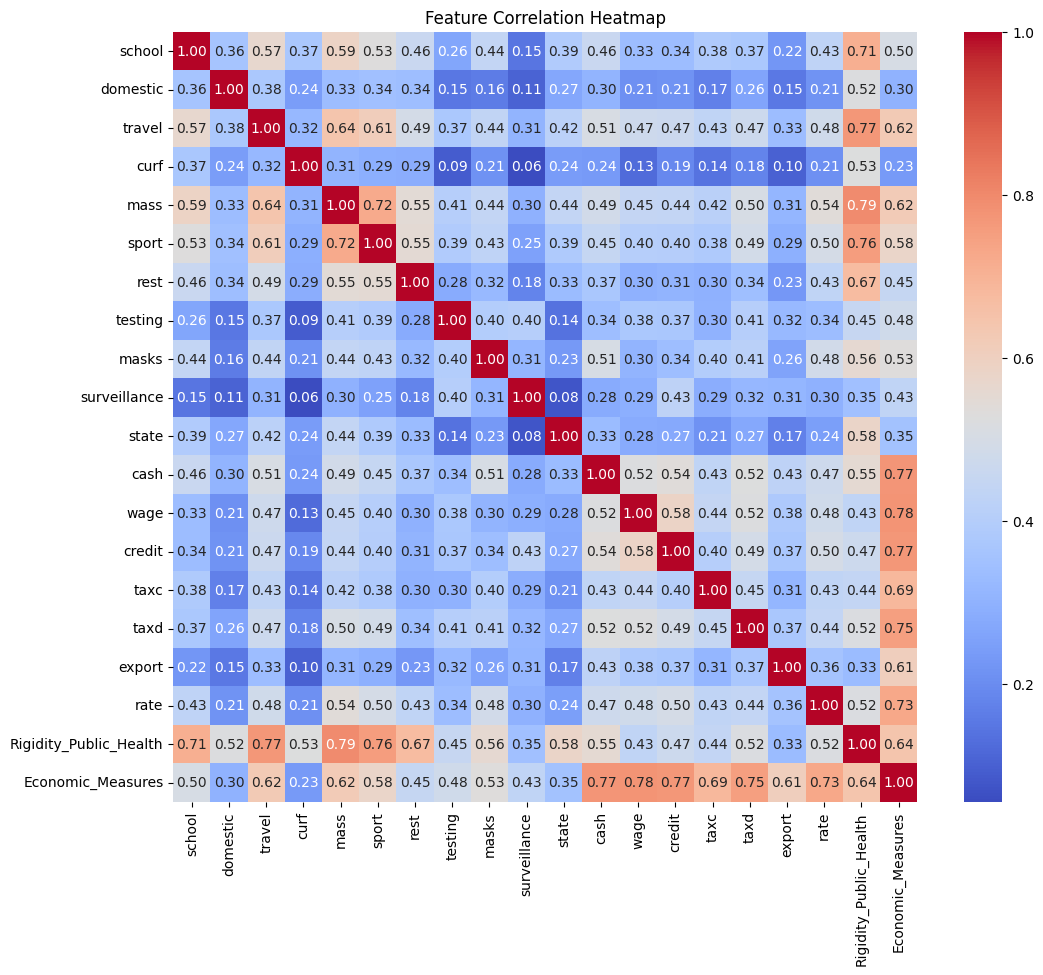


Logistic Regression Results:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      4156
         Low       1.00      0.99      0.99      4182
      Medium       0.99      1.00      0.99      4202

    accuracy                           1.00     12540
   macro avg       1.00      1.00      1.00     12540
weighted avg       1.00      1.00      1.00     12540

Confusion Matrix:
 [[4141    0   15]
 [   0 4151   31]
 [   0   13 4189]]

Gradient Boosting Results:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      4156
         Low       1.00      1.00      1.00      4182
      Medium       1.00      1.00      1.00      4202

    accuracy                           1.00     12540
   macro avg       1.00      1.00      1.00     12540
weighted avg       1.00      1.00      1.00     12540

Confusion Matrix:
 [[4156    0    0]
 [   0 4182    0]
 [   0    0 4202]]

Decision Tree Results:
        

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
df = pd.read_csv("/content/preprocessed_dataset.csv")

# Checking column names
print("Dataset Columns:", df.columns)

# Creating Policy_Stringency if not found
if 'Policy_Stringency' not in df.columns:
    print("Column 'Policy_Stringency' not found. Creating based on thresholds.")
    if 'Rigidity_Public_Health' in df.columns and 'Economic_Measures' in df.columns:
        df['Policy_Stringency'] = pd.qcut(df['Rigidity_Public_Health'] + df['Economic_Measures'],
                                          q=3, labels=['Low', 'Medium', 'High'])
    else:
        raise ValueError("Required columns for classification are missing.")

# Checking class distribution
print("Policy Stringency Distribution:\n", df['Policy_Stringency'].value_counts())

# Selecting relevant features
features = ['school', 'domestic', 'travel', 'curf', 'mass', 'sport', 'rest', 'testing',
            'masks', 'surveillance', 'state', 'cash', 'wage', 'credit', 'taxc', 'taxd',
            'export', 'rate', 'Rigidity_Public_Health', 'Economic_Measures']
target = 'Policy_Stringency'

# Compute correlation matrix
correlation_matrix = df[features].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

# Remove highly correlated features (threshold > 0.85)
high_corr_features = set()
correlation_threshold = 0.85
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            high_corr_features.add(colname)

filtered_features = [f for f in features if f not in high_corr_features]

# Splitting data into train and test
X = df[filtered_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalizing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Function to train and evaluate a model
def train_and_evaluate(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{model_name} Results:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return accuracy_score(y_test, y_pred)

# Model 1: Logistic Regression
logreg = LogisticRegression()
acc_logreg = train_and_evaluate(logreg, "Logistic Regression")

# Model 2: Gradient Boosting Classifier
gb = GradientBoostingClassifier()
acc_gb = train_and_evaluate(gb, "Gradient Boosting")

# Model 3: Decision Tree Classifier
dt = DecisionTreeClassifier()
acc_dt = train_and_evaluate(dt, "Decision Tree")

# Model 4: Naive Bayes Classifier
nb = GaussianNB()
acc_nb = train_and_evaluate(nb, "Naive Bayes")

# Compare Model Accuracies
model_accuracies = {
    "Logistic Regression": acc_logreg,
    "Gradient Boosting": acc_gb,
    "Decision Tree": acc_dt,
    "Naive Bayes": acc_nb
}

# Print model performance summary
print("\nModel Performance Summary:")
for model, acc in model_accuracies.items():
    print(f"{model}: {acc:.4f}")


#DL Models Without VIF Filtering


Dataset Columns: Index(['country', 'geoid', 'iso', 'd', 'cases', 'deaths', 'school',
       'school_local', 'domestic', 'domestic_local', 'travel',
       'travel_partial', 'travel_dom', 'travel_dom_partial', 'curf',
       'curf_partial', 'mass', 'mass_partial', 'sport', 'sport_partial',
       'rest', 'rest_local', 'testing', 'testing_narrow', 'masks',
       'masks_partial', 'surveillance', 'surveillance_partial', 'state',
       'state_partial', 'cash', 'wage', 'credit', 'taxc', 'taxd', 'export',
       'rate', 'Rigidity_Public_Health', 'Economic_Measures',
       'population_2019', 'continent'],
      dtype='object')
Column 'Policy_Stringency' not found. Creating based on thresholds.


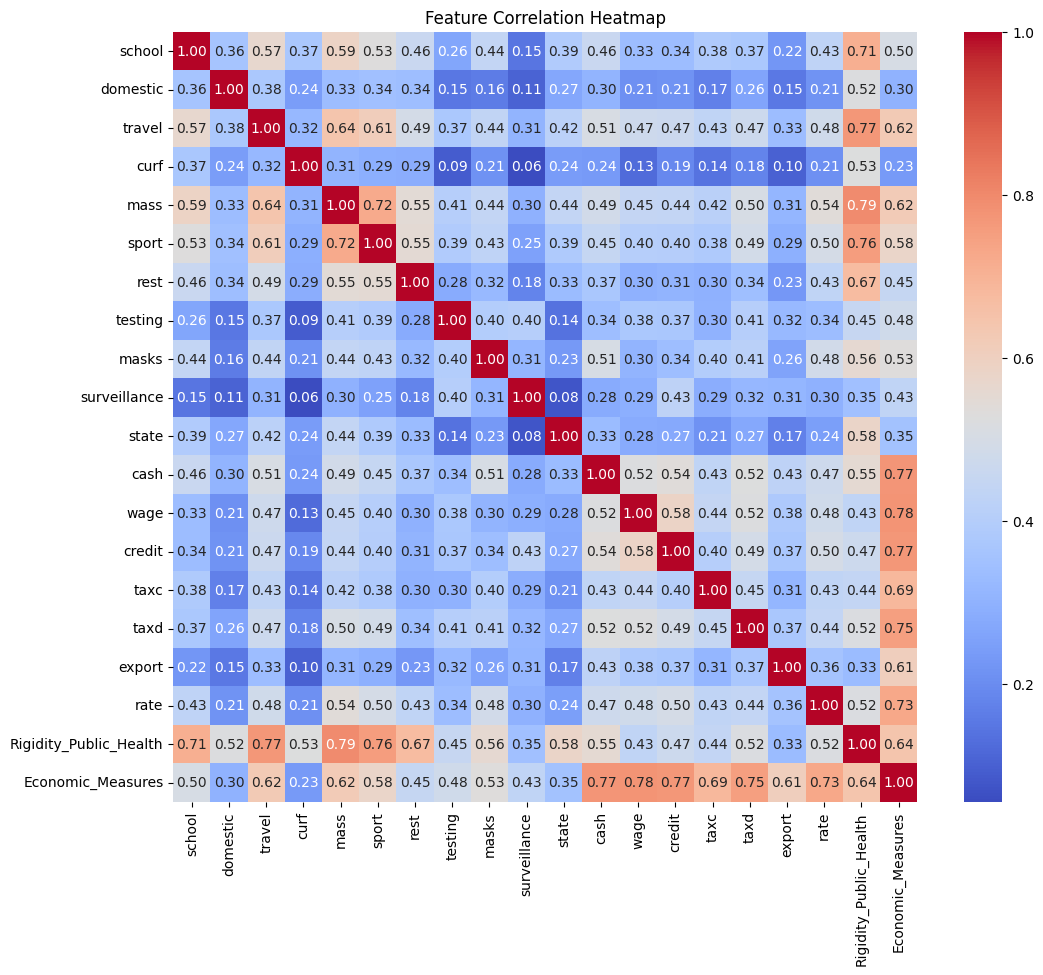

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3135/3135 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8869 - loss: 0.2614 - val_accuracy: 0.9817 - val_loss: 0.0489
Epoch 2/10
3135/3135 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9693 - loss: 0.0771 - val_accuracy: 0.9892 - val_loss: 0.0282
Epoch 3/10
3135/3135 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9812 - loss: 0.0490 - val_accuracy: 0.9932 - val_loss: 0.0197
Epoch 4/10
3135/3135 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9866 - loss: 0.0343 - val_accuracy: 0.9948 - val_loss: 0.0150
Epoch 5/10
3135/3135 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9887 - loss: 0.0309 - val_accuracy: 0.9949 - val_loss: 0.0131
Epoch 6/10
3135/3135 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9901 - loss: 0.0266 - val_accuracy: 0.9951 - val_loss: 0.0111
Epoch 7/10
3135/3135 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9915 - loss: 0.0241 - val_accuracy: 0.9961 - val_loss: 0.0128
Epoch 8/10
3135/3135 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9925 - loss: 0.0213 - val

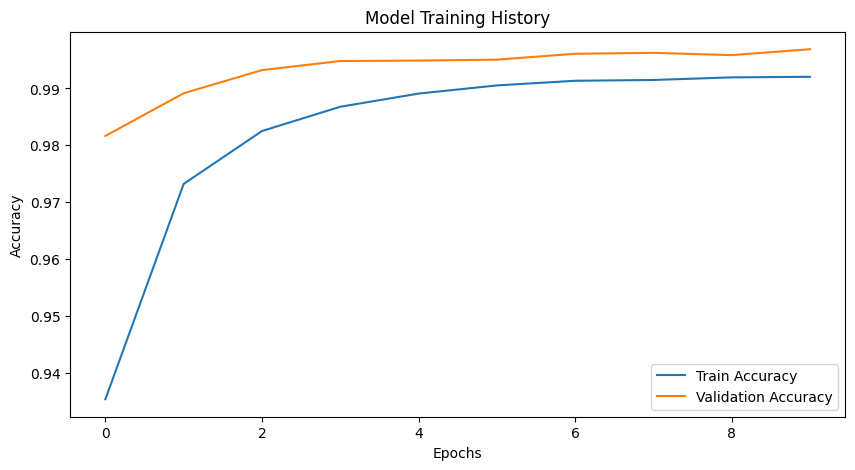

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load dataset
df = pd.read_csv("/content/preprocessed_dataset.csv")

# Checking column names
print("Dataset Columns:", df.columns)

# Creating Policy_Stringency if not found
if 'Policy_Stringency' not in df.columns:
    print("Column 'Policy_Stringency' not found. Creating based on thresholds.")
    if 'Rigidity_Public_Health' in df.columns and 'Economic_Measures' in df.columns:
        df['Policy_Stringency'] = pd.qcut(df['Rigidity_Public_Health'] + df['Economic_Measures'],
                                          q=3, labels=['Low', 'Medium', 'High'])
    else:
        raise ValueError("Required columns for classification are missing.")

# Encoding target variable
label_encoder = LabelEncoder()
df['Policy_Stringency'] = label_encoder.fit_transform(df['Policy_Stringency'])

# Selecting relevant features
features = ['school', 'domestic', 'travel', 'curf', 'mass', 'sport', 'rest', 'testing',
            'masks', 'surveillance', 'state', 'cash', 'wage', 'credit', 'taxc', 'taxd',
            'export', 'rate', 'Rigidity_Public_Health', 'Economic_Measures']
target = 'Policy_Stringency'

# Compute correlation matrix
correlation_matrix = df[features].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

# Remove highly correlated features (threshold > 0.85)
high_corr_features = set()
correlation_threshold = 0.85
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            high_corr_features.add(colname)

filtered_features = [f for f in features if f not in high_corr_features]

# Splitting data into train and test
X = df[filtered_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalizing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert labels to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Building Deep Learning Model
def create_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate the model
model = create_model()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16, verbose=1)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nDeep Learning Model Accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Training History')
plt.show()

#DL Models With VIF Filtering

Dataset Columns: Index(['country', 'geoid', 'iso', 'd', 'cases', 'deaths', 'school',
       'school_local', 'domestic', 'domestic_local', 'travel',
       'travel_partial', 'travel_dom', 'travel_dom_partial', 'curf',
       'curf_partial', 'mass', 'mass_partial', 'sport', 'sport_partial',
       'rest', 'rest_local', 'testing', 'testing_narrow', 'masks',
       'masks_partial', 'surveillance', 'surveillance_partial', 'state',
       'state_partial', 'cash', 'wage', 'credit', 'taxc', 'taxd', 'export',
       'rate', 'Rigidity_Public_Health', 'Economic_Measures',
       'population_2019', 'continent'],
      dtype='object')
Column 'Policy_Stringency' not found. Creating based on thresholds.


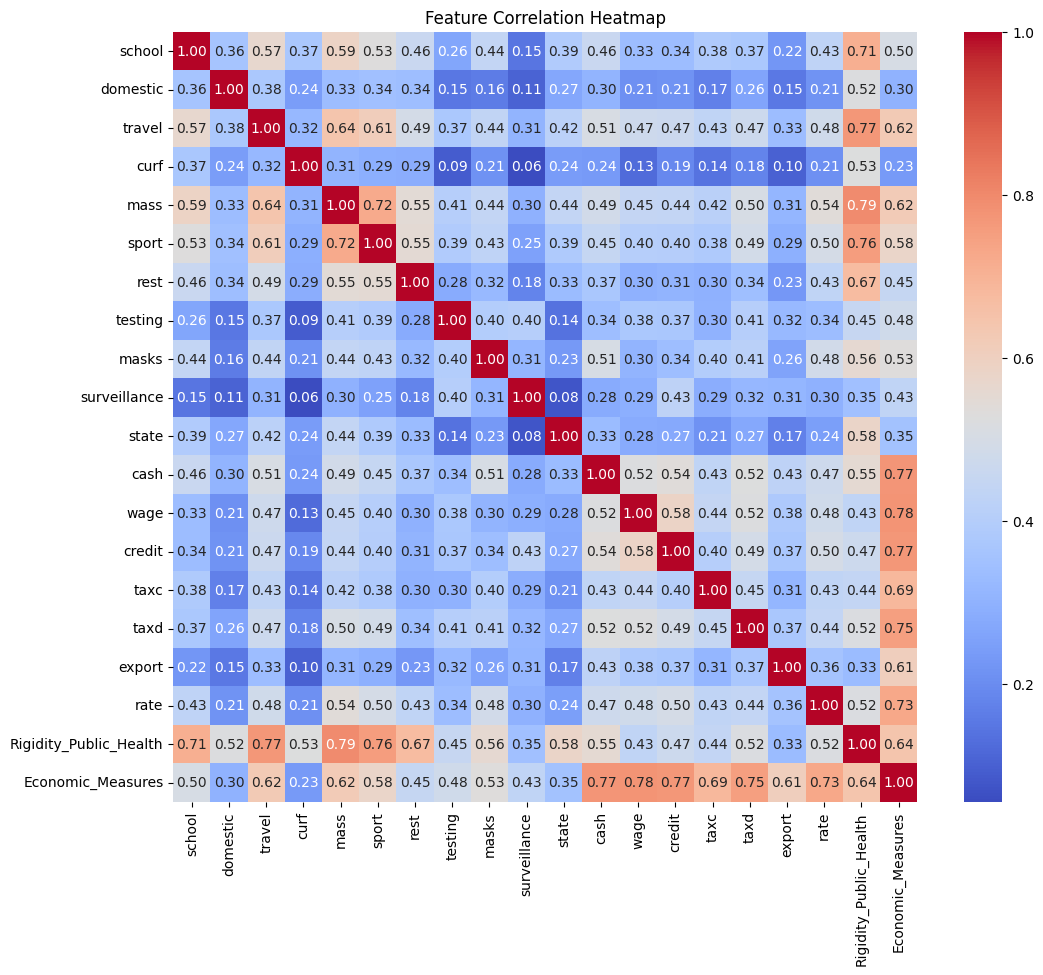

Selected Features after VIF filtering: ['school', 'domestic', 'travel', 'curf', 'mass', 'sport', 'rest', 'testing', 'masks', 'surveillance', 'state']
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3135/3135 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7758 - loss: 0.4959 - val_accuracy: 0.8216 - val_loss: 0.3723
Epoch 2/20
3135/3135 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.8216 - loss: 0.3955 - val_accuracy: 0.8475 - val_loss: 0.3516
Epoch 3/20
3135/3135 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8359 - loss: 0.3763 - val_accuracy: 0.8442 - val_loss: 0.3411
Epoch 4/20
3135/3135 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8364 - loss: 0.3662 - val_accuracy: 0.8499 - val_loss: 0.3286
Epoch 5/20
3135/3135 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8422 - loss: 0.3516 - val_accuracy: 0.8502 - val_loss: 0.3240
Epoch 6/20
3135/3135 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8450 - loss: 0.3489 - val_accuracy: 0.8545 - val_loss: 0.3191
Epoch 7/20
3135/3135 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8461 - loss: 0.3456 - val_accuracy: 0.8543 - val_loss: 0.3170
Epoch 8/20
3135/3135 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8446 - loss: 0.3430 - val_

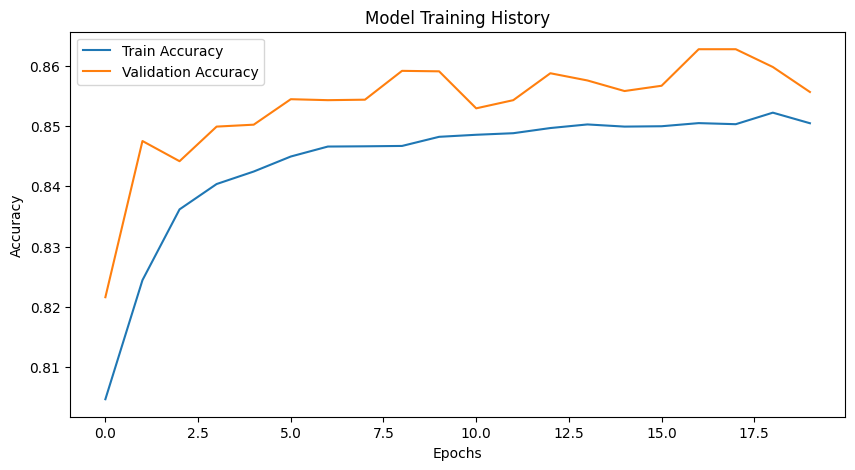

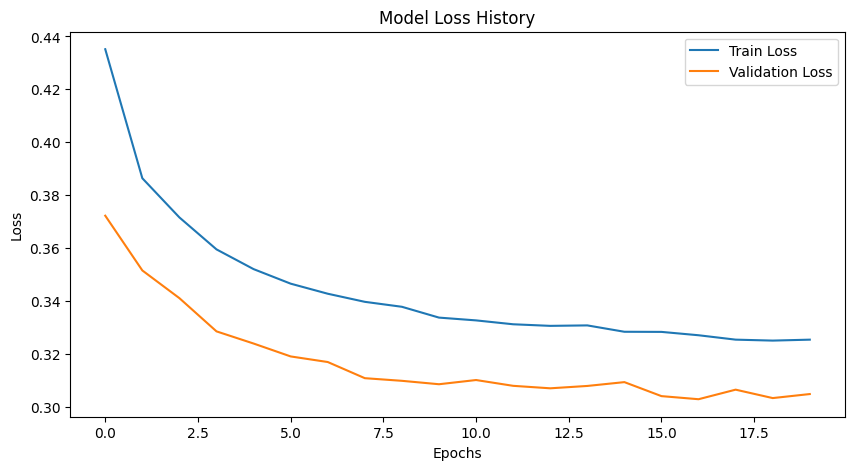

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load dataset
df = pd.read_csv("/content/preprocessed_dataset.csv")

# Checking column names
print("Dataset Columns:", df.columns)

# Creating Policy_Stringency if not found
if 'Policy_Stringency' not in df.columns:
    print("Column 'Policy_Stringency' not found. Creating based on thresholds.")
    if 'Rigidity_Public_Health' in df.columns and 'Economic_Measures' in df.columns:
        df['Policy_Stringency'] = pd.qcut(df['Rigidity_Public_Health'] + df['Economic_Measures'],
                                          q=3, labels=['Low', 'Medium', 'High'])
    else:
        raise ValueError("Required columns for classification are missing.")

# Encoding target variable
label_encoder = LabelEncoder()
df['Policy_Stringency'] = label_encoder.fit_transform(df['Policy_Stringency'])

# Selecting relevant features
features = ['school', 'domestic', 'travel', 'curf', 'mass', 'sport', 'rest', 'testing',
            'masks', 'surveillance', 'state', 'cash', 'wage', 'credit', 'taxc', 'taxd',
            'export', 'rate', 'Rigidity_Public_Health', 'Economic_Measures']
target = 'Policy_Stringency'

# Compute correlation matrix
correlation_matrix = df[features].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

# Remove highly correlated features (threshold > 0.85)
high_corr_features = set()
correlation_threshold = 0.85
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            high_corr_features.add(colname)

filtered_features = [f for f in features if f not in high_corr_features]

# Calculate VIF and remove features with VIF > 10
def calculate_vif(df, features):
    X = df[features].fillna(0)  # Handle missing values
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_df = calculate_vif(df, filtered_features)
filtered_features = vif_df[vif_df["VIF"] < 10]["Feature"].tolist()
print("Selected Features after VIF filtering:", filtered_features)

# Splitting data into train and test
X = df[filtered_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalizing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert labels to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Building Deep Learning Model
def create_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate the model
model = create_model()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16, verbose=1)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nDeep Learning Model Accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Training History')
plt.show()

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss History')
plt.show()
